In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.integrate
import pymc3 as pm

## Are today's sales lower than yesterday's because of randomness, or should I be worried?

Suppose we're looking at transactions per day for a low-volume online store we've just opened.

We've noticed that we've sold 5 items yesterday and 3 items today.

It's really hard to tell if this is an **important** difference, ie. is something causing sales to go down, or unimportant, ie. we're just seeing random fluctuations.

How do we deal with this? We need a way to quantify the concept of "important" change. 

* [Spherical cows: mathematical models of sales over time](#Spherical-cows:-mathematical-models-of-sales-over-time)
* [How do we formalize the question?](#How-do-we-formalize-the-question?)
    * [Bayesian model comparison](#Bayesian-model-comparison)
        * [The model comparison question](#The-model-comparison-question)
        * [The model comparison answer](#The-model-comparison-answer)
    * [Proportionality](#Proportionality)
        * [The proportionality question](#The-proportionality-question)
        * [The proportionality answer](#The-proportionality-answer)
    * [Examples](#Examples)
* [Conclusions](#conclusions)

## Spherical cows: mathematical models of sales over time

We want [the simplest possible model](https://en.wikipedia.org/wiki/Spherical_cow) we can find that:
* lets us formulate our question "is the difference between today's sales and yesterday's due to chance?"
* does not make assumptions or simplifications that are obviously inapplicable to our case

One way to frame this question is in terms of the **expected sales rate**, that is, how many sales are expected to occur per unit time. 

Sales depend on a huge amount of factors that are constantly changing: the quality of the product, ad campaigns, the mood of the purchasers, the economy, phase of the moon etc. A model taking all that into account would be hopelessly complex.

We'll simplify the situation by saying all those factors determine an (unknown) daily sales rate we'll call $\mu$: the number of sales in a day is a random variable that depends on this unknown rate $\mu$.

This yields a much simpler model, as now we only need to deal with the number $\mu$ instead of all those other factors.

#### Exactly how does the sales rate $\mu$ affect sales?

We'll choose a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) to describe the dependency between the number of sales in a day $day_i$ and the sales rate that day $\mu_i$:

$$
day_i \sim \operatorname{Poisson}(\mu_i)
$$

In our situation: 
* we have daily counts: $day_1$ and $day_2$
* we assume these counts depend on unknown underlying rates $\mu_1$ and $\mu_2$ for each day
* we are interested in the question: is it reasonable to believe the rates $\mu_1$ and $\mu_2$ are different or the same, given the daily count data $day_1$ and $day_2$?

## How do we formalize the question?

So we have our spherical cow: the count for $day_1$ is drawn from a Poisson distribution with rate $\mu_1$, the count for $day_2$ is drawn from a Poisson distribution with rate $\mu_2$.

**How can we quantitatively ask "is it reasonable to believe $\mu_1$ is different from $\mu_2$ ?"**

I just don't understand most of the orthodox (frequentist) methods, not for lack of trying: I believe the questions the orthodox methods are answering are different from the questions I am interested in asking. See [E.T. Jaynes](https://bayes.wustl.edu/etj/articles/confidence.pdf) for entertaining and enlightening polemics.

I've found (at least) 2 interesting ways to quantify aspects of this question, the approaches are complementary:
* **via model comparison**: build 2 models and find the higher-scoring one using Bayesian model comparison
    * one model assumes a single underlying $\mu$ for both days
    * the other model assumes distinct $\mu_1$ and $\mu_2$ for the days
* **via a proportionality constant relating the rates**: assume $\mu_2 = k \cdot \mu_1$ and look at the plausible values for this constant: values near 1 indicate that the rates are similar, values away from one indicate difference (and the magnitude of that difference).

### Bayesian model comparison

Bayesian model comparison can tell us which model is appropriate for the situation, and quantify *how much more* appropriate one model is than the other. Bayes factors are an extremely powerful formalization of common sense, for very deep reasons. [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor) is a natural consequence of applying Bayesian model comparison: in this case we're asking a quantitative version of Occam's razor, as in, do we need 1 parameter ($\mu$) to describe the data, or 2 ($\mu_1$, $\mu_2$)?

#### The model comparison question

To frame this as a model comparison question,  we build:

##### Model 1 where both days share the same underlying rate $\mu$

* $\mu \sim U(0.001, 100)$
* $day_1 \sim Poisson(\mu)$
* $day_2 \sim Poisson(\mu)$

##### Model 2 where the days have different rates $\mu_1$, $\mu_2$

* $\mu_1 \sim U(0.001, 100)$
* $\mu_2 \sim U(0.001, 100)$
* $day_1 \sim Poisson(\mu_1)$
* $day_2 \sim Poisson(\mu_2)$

I'm taking a uniform prior (for illustration purposes) for the rates $mu_i$ consistent with our expectations for a small store, ranging from:
* a sale every 100 days
* 100 sales a day

And ask: **which is the better model according to the Bayes factor?**


#### The model comparison answer

We're looking for the [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor): 

$$
\frac{Pr(day_1=5, day_2=3 \mid model_1)}{Pr(day_1=5, day_2=3 \mid model_2)}
$$

So we need to integrate out each model's parameters:

##### Model 1: common rate $\mu$ for both days

$$
Pr(day_1=5, day_2=3 \mid model_1) = \int_{0.01}^{100} 
\frac{\mu ^ 5
    \cdot 
e ^ {-\mu}}{5!}
    \cdot
\frac{\mu ^ 3
    \cdot 
e ^ {-\mu}}{3!}
\cdot
\frac{1}{100 - 0.01}
d \mu
$$

#### Model 2: distinct rates $\mu_1$ and $\mu_2$ 

$$
Pr(day_1=5, day_2=3 \mid model_2) = 
\int_{0.01}^{100} \int_{0.01}^{100}
\frac{\mu_1 ^ 5 
    \cdot 
e ^ {- \mu_1}}{5!}
    \cdot
\frac{1}{100 - 0.01}
\cdot
\frac{\mu_2 ^ 3 
    \cdot 
e ^ {- \mu_2}}{3!}
    \cdot
\frac{1}{100 - 0.01}
d \mu_1
d \mu_2
$$

In [2]:
poisson_pmf = scipy.stats.poisson.pmf

def model_1_prob(day_1, day_2):
    a = 0.001
    b = 100
    f = lambda mu: poisson_pmf(day_1, mu) * poisson_pmf(day_2, mu) / (100 - 0.01)
    return scipy.integrate.quad(f, a, b) 

def model_2_prob(day_1, day_2):
    a = 0.001
    b = 100
    gfun = lambda x: a
    hfun = lambda x: b
    
    f = lambda mu1, mu2: poisson_pmf(day_1, mu1) * poisson_pmf(day_2, mu2) / ((100 - 0.01) ** 2)
    
    return scipy.integrate.dblquad(f, a, b, gfun, hfun)
    

def bayes_factor_bits(day_1, day_2):
    res_1 = model_1_prob(day_1, day_2)
    res_2 = model_2_prob(day_1, day_2)
    
    k = res_1[0] / res_2[0]
    
    return np.log2(k)


Armed with the function that calculates the bayes factor, actually the log bayes factor base 2, in bits, and [a table for interpreting the bayes factor quantitatively](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation) we can ask the initial question:

**If I sold 5 items yesterday and 3 items today, is it plausible to believe the sales rate has changed?**

In [3]:
bayes_factor_bits(5, 3)

3.4510668352803506

`3.45` bits means there's strong support for thinking **the rate has not changed**.

Let's game out a few cases and see what the Bayes factor tells us:

In [4]:
for day_1, day_2 in [(5, 3), (5, 0), (12, 2)]:
    bayes_f = bayes_factor_bits(day_1, day_2)
    print('day 1: {0}, day2: {1} bayes: {2}'.format(day_1, day_2, bayes_f))

day 1: 5, day2: 3 bayes: 3.4510668352803506
day 1: 5, day2: 0 bayes: 0.6451546081674681
day 1: 12, day2: 2 bayes: -1.848493446499082


* 5, 3: the original question, strong support for no change
* 5, 0: don't know whether the rate has changed or not, both scenarios are plausible
* 12, 2: strong support for the rate having changed from one day to the other

### Proportionality

We assume that $\mu_2$ is related to $\mu_1$ via a constant factor $k$: examining the distribution of the plausible values for this $k$ will show us the relationship between $\mu_1$ and $\mu_2$.

To model this situation:
* $\mu_1 \sim U(0.001, 100)$
* $k \sim U(0.001, 100)$
* $day_1 \sim \operatorname{Poisson}(\mu_1)$
* $day_2 \sim \operatorname{Poisson}(k \cdot \mu_1)$

#### The proportionality question

If we assume the daily rates are related by a constant: $\mu_2 = k \cdot \mu_1$, what is the probability distribution of $k$ given the data?

#### The proportionality answer

The answer to the question is a probability density over $k$.

We'll use the excellent [pymc3](https://docs.pymc.io/), which means we can write down the model essentially verbatim:

In [5]:
def make_proportional_model(day_1_count, day_2_count):
    model = pm.Model()

    with model:

        # prior for poisson
        mu = pm.Uniform('mu', lower = 0.01, upper = 100)
    
        # prior for k
        k = pm.Uniform('k', lower = 0.01, upper = 100)

        day_1 = pm.Poisson('day_1', mu, observed=day_1_count)
        day_2 = pm.Poisson('day_2', k * mu, observed=day_2_count)
    return model
        

We can perform inference for the original question:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [k, mu]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 15 seconds.
/Users/miguelsimon/ejercicios/datos_univariados_2/env/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1271effd0>,
      dtype=object)

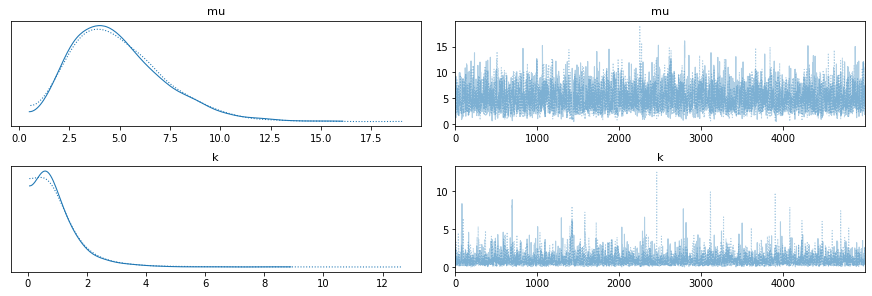

In [6]:
model = make_proportional_model(5, 3)
with model:
    trace = pm.sample(5000)
    
pm.traceplot(trace)

(0.24307722323263223, 0.8030515555092541, 2.632475897207885)

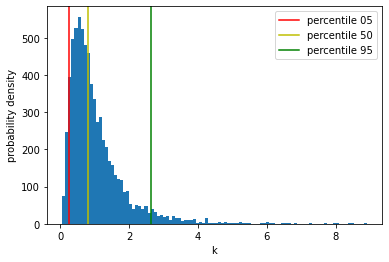

In [7]:
k = trace['k'][:-3000]

a, b, c = np.percentile(k, 5), np.percentile(k, 50), np.percentile(k, 95)

_ = plt.hist(k, bins=100)

plt.xlabel("k")
plt.ylabel("probability density")
plt.axvline(a, c = 'r', label="percentile 05")
plt.axvline(b, c = 'y', label="percentile 50")
plt.axvline(c, c = 'g', label="percentile 95")
plt.legend()

a, b, c

We observe that a [credible interval](https://en.wikipedia.org/wiki/Credible_interval) that contains 90% of the probability mass of $k$ ranges from (0.23, 2.49). This is consistent with the answer provided by Bayesian model comparison: k has a broad distribution, we don't really have a reason to believe it is smaller, greater or equal than 1.

## Examples

TODO

## Conclusions

The two approaches formalize different questions that are related to our core concern:

* the Bayesian model comparison tells us whether there are systematic differences between the two days
* the density of the proportionality constant lets us quantify the magnitude of the differences

I find them especially useful in the small-sample, small-rate cases, where my intuition seems to be pretty useless.